In [1]:
import pandas as pd
import os
import numpy as np
from core.helpers import true_pred_clouds
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import tensorflow
from tensorflow import keras

rcdict = {
    
    'grid.linewidth'	: 1,
    'xtick.major.size'	: 0,
    'ytick.major.size'	: 0,
    'xtick.minor.size'	: 0,
    'ytick.minor.size'	: 0,
    'axes.labelpad'		: 10.0
    
}

jtplot.style(theme='grade3', context='talk', fscale=1.4, spines=False, gridlines='--')
sns.set_context('talk', rc=rcdict)

## Data preprocessing 

In [2]:
train = pd.read_csv('train.csv')
target = 'SalePrice'

### 1. Target variable

Firstly let's look at the target (`SalePrice`) distribution:

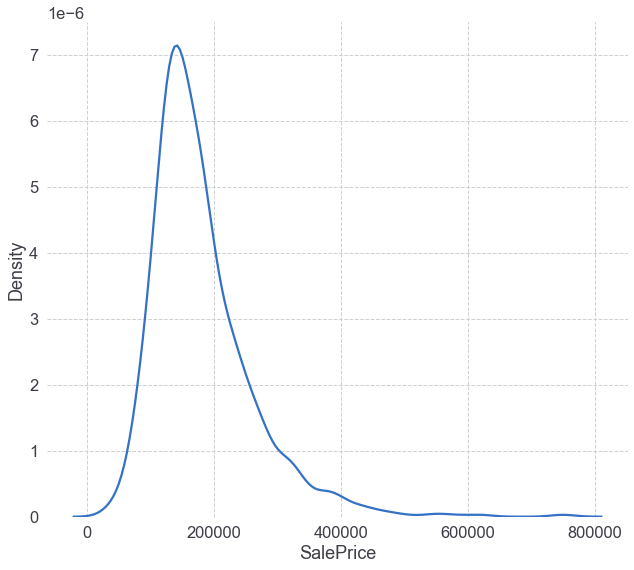

In [3]:
_ = sns.kdeplot(data=train, x=target)

We can witness a pure logarithmic dependence, so let's take $\log$ from our target variable to normalize the distribution.

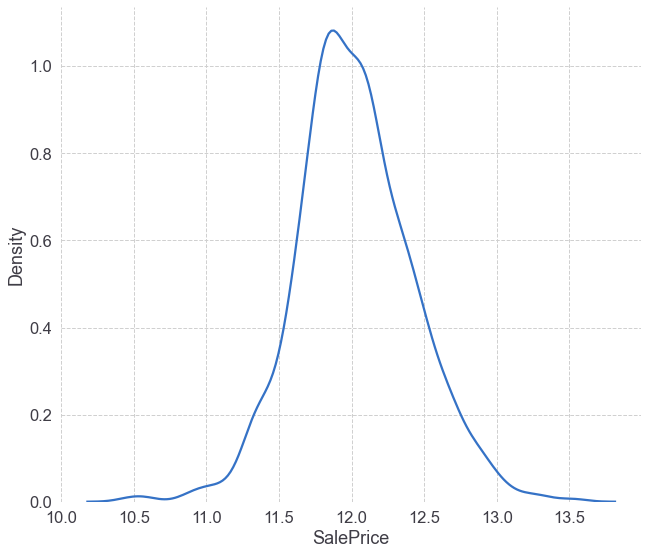

In [4]:
train[target] = train[target].apply(np.log)
_ = sns.kdeplot(data=train, x=target)

Seems more like a normal distribution amd that is much more adequate for us to create robust regression model.

let us deal with all features according to the description.

### 2. Categorical features

There are several categorical features:

1. `MSSubClass` : Identifies the type of dwelling involved in the sale;
2. `MSZoning` : Identifies the general zoning classification of the sale;
3. `Street` : Type of road access to property;
4. `Alley` : Type of alley access to property;
5. `LotShape` : General shape of property;
6. `LandContour` : Flatness of the property;
7. `LotConfig`: Lot configuration;
8. `Utilities` : Type of utilities available;
9. `LandSlope` : Slope of property;
10. `Neighborhood` : Physical locations within Ames city limits;
11. `Condition1` : Proximity to various conditions;
12. `Condition2` : Proximity to various conditions (if more than one is present);
13. `BldgType` : Type of dwelling;
14. `HouseStyle` : Style of dwelling;
15. `RoofStyle` : Type of roof;
16. `RoofMatl` : Roof material;
17. `Exterior1st` : Exterior covering on house;
18. `Exterior2nd` : Exterior covering on house (if more than one material);
19. `MasVnrType` : Masonry veneer type;
20. `ExterQual` : Evaluates the quality of the material on the exterior; **ranked**
21. `ExterCond` : Evaluates the present condition of the material on the exterior; **ranked**
22. `Foundation` : Type of foundation;
23. `BsmtQual` : Evaluates the height of the basement; **ranked**
24. `BsmtCond` : Evaluates the general condition of the basement; **ranked**
25. `BsmtExposure` : Refers to walkout or garden level walls; **ranked**
26. `BsmtFinType1` : Rating of basement finished area; **ranked**
27. `BsmtFinType2` : Rating of basement finished area (if multiple types); **ranked**
28. `Heating` : Type of heating;
29. `HeatingQC` : Heating quality and condition; **ranked**
30. `CentralAir` : Central air conditioning;
31. `Electrical` : Electrical system;
32. `KitchenQual` : Kitchen quality; **ranked**
33. `Functional` : Home functionality (Assume typical unless deductions are warranted); **ranked**
34. `FireplaceQu` : Fireplace quality; **ranked**
35. `GarageType` : Garage location;
36. `GarageFinish` : Interior finish of the garage;
37. `GarageQual` : Garage quality; **ranked**
38. `GarageCond` : Garage condition; **ranked**
39. `PavedDrive` : Paved driveway;
40. `PoolQC` : Pool quality; **ranked**
41. `Fence` : Fence quality;
42. `MiscFeature` : Miscellaneous feature not covered in other categories;
43. `SaleType` : Type of sale;
44. `SaleCondition` : Condition of sale.

Some of features from the list are marked with **ranked** tag - these features need to be converted to a scalar value for further purposes and scale if needed; other ones will be expanded with `OneHotEncoder` to look at correlations with the target variable for feature filtering.

In [5]:
_RANKED = {
    
    'ExterQual' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual'  : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond'  : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure' : ['Mo', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1' : ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2' : ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional' : ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond' : ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PoolQC' : ['Po', 'Fa', 'TA', 'Gd', 'Ex']
    
}

def convert_to_ranked(data, ranks: dict = _RANKED):
    
    df = data.copy()
    
    for col, pal in ranks.items():
        
        df[col] = df[col].apply(lambda x: pal.index(x) if x in pal else 0)
    
    
    return df

train = convert_to_ranked(train)

OneHotEncoding with other features:

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

_ONEHOT = [
    
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Utilities',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'GarageType',
    'GarageFinish',
    'PavedDrive',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition',

]

ohe.fit(train[_ONEHOT])
col_names = ohe.get_feature_names(_ONEHOT)

ohe_df = pd.DataFrame(data=ohe.transform(train[_ONEHOT]), columns=col_names)
ohe_df[target] = train[target].copy()

Let's take a look on largest (by module) correlations

In [7]:
ohe_corrs = ohe_df.corr()[target].to_dict()
ohe_corrs = dict(map(lambda x: (x[0], abs(x[1])), ohe_corrs.items()))
ohe_corrs = dict(sorted(ohe_corrs.items(), key=lambda x: x[1], reverse=True))
ohe_corrs

{'SalePrice': 1.0,
 'Foundation_PConc': 0.5308399984857171,
 'GarageFinish_Unf': 0.43201123360275884,
 'GarageFinish_Fin': 0.4188809886414385,
 'GarageType_Attchd': 0.41578714941729694,
 'MSSubClass_60': 0.4015004955507629,
 'MasVnrType_None': 0.39538932223728784,
 'GarageType_Detchd': 0.388637966926843,
 'Neighborhood_NridgHt': 0.3518021831714615,
 'CentralAir_N': 0.3516001835925244,
 'CentralAir_Y': 0.35160018359252426,
 'MSZoning_RM': 0.34744607354680224,
 'Foundation_CBlock': 0.33781460403306846,
 'Exterior2nd_VinylSd': 0.33744358506423094,
 'Exterior1st_VinylSd': 0.336138195531359,
 'MSSubClass_30': 0.3292117887972399,
 'SaleType_New': 0.32918953445265753,
 'SaleCondition_Partial': 0.3244709951499805,
 'GarageType_nan': 0.3229985232994614,
 'GarageFinish_nan': 0.3229985232994614,
 'MasVnrType_Stone': 0.31136932565860964,
 'Electrical_SBrkr': 0.30486162038616343,
 'PavedDrive_Y': 0.2999590378920953,
 'MSZoning_RL': 0.2988622246198173,
 'LotShape_Reg': 0.28963467715835034,
 'PavedDr

So, we have really good correlations with some of categorical features - let's implement the threshold for correlation and select only good features (we may manipulate with this threshold later):

In [8]:
ohe_corr_threshold = 0.1
ohe_important = [x for x, y in ohe_corrs.items() if x != target and y >= ohe_corr_threshold]

train[ohe_important] = ohe_df[ohe_important].copy()
train.drop(_ONEHOT, inplace=True, axis=1) # don't forget to drop encoded columns

### 3. Artificial features

Let's design several artificial features related to time:

In [9]:
train['GarageYrBlt'].fillna(0, inplace=True)

train['Age'] = train['YrSold'] - train['YearBuilt']
train['AgeRemod'] = train['YrSold'] - train['YearRemodAdd']
train['GarageAge'] = (train['YrSold'] - train['GarageYrBlt']) * (train['GarageYrBlt'] > 0).astype(int)

train.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

### 4. Correlations overview

Filter out very poor features with the same threshold:

In [10]:
temp = train.drop(ohe_important + list(_RANKED.keys()), axis=1).copy()

temp_corrs = temp.corr()[target].to_dict()
temp_corrs = dict(map(lambda x: (x[0], abs(x[1])), temp_corrs.items()))
temp_corrs = dict(sorted(temp_corrs.items(), key=lambda x: x[1], reverse=True))
temp_corrs

{'SalePrice': 1.0,
 'OverallQual': 0.8171844179216803,
 'GrLivArea': 0.7009266525441309,
 'GarageCars': 0.6806248074360484,
 'GarageArea': 0.6508875559020071,
 'TotalBsmtSF': 0.612133975369786,
 '1stFlrSF': 0.5969810450343734,
 'FullBath': 0.5947705420075331,
 'Age': 0.5872900470291362,
 'AgeRemod': 0.5681357285300426,
 'TotRmsAbvGrd': 0.5344222037231263,
 'Fireplaces': 0.48944942759848536,
 'MasVnrArea': 0.43080852419510907,
 'GarageAge': 0.3960533964880333,
 'BsmtFinSF1': 0.372023073567088,
 'LotFrontage': 0.355878470385983,
 'WoodDeckSF': 0.3341350739575106,
 'OpenPorchSF': 0.3210529720197675,
 '2ndFlrSF': 0.3192999843472049,
 'HalfBath': 0.31398224991514884,
 'LotArea': 0.25731989235273783,
 'BsmtFullBath': 0.23622410882434952,
 'BsmtUnfSF': 0.22198505352520947,
 'BedroomAbvGr': 0.209043682126922,
 'EnclosedPorch': 0.14905028142767662,
 'KitchenAbvGr': 0.14754808847658074,
 'ScreenPorch': 0.12120760489686307,
 'PoolArea': 0.06979780600969471,
 'MoSold': 0.0573294845979106,
 '3SsnPo

In [11]:
temp_corr_threshold = 0.1
temp_poor = [x for x, y in temp_corrs.items() if x != target and y < temp_corr_threshold]

train.drop(temp_poor, axis=1, inplace=True)

### 5. Filling NaN values

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 128 entries, LotFrontage to GarageAge
dtypes: float64(91), int64(37)
memory usage: 1.4 MB


In [13]:
train = train.fillna(0) # because of done conversions

### 6. Scaling non-encoded features

In [14]:
class StandardScaler:
    
    def __init__(self, features):
        
        self.features = features
    
    # ------------------------- #

    def fit(self, data):

        df = data.copy()

        self.mu = [

            float(df[x].mean()) 
            for x in self.features

        ]

        self.sigma = [

            float(df[x].std()) 
            for x in self.features

        ]
        

        return self
    
    # ------------------------- #

    def transform(self, data):

        df = data.copy()


        for x, m, s in zip(self.features, self.mu, self.sigma):
            
            df[x] = (df[x] - m) / s
        

        return df
    
    # ------------------------- #

    def inverse_transform(self, data):

        df = data.copy()


        for x, m, s in zip(self.features, self.mu, self.sigma):
            
            df[x] = df[x] * s + m

        
        return df

In [15]:
non_encoded = train.drop([target] + ohe_important, axis=1).columns

scaler = StandardScaler(features=non_encoded)
scaler.fit(train)

train = scaler.transform(train)

## Modeling

In [16]:
from sklearn.model_selection import train_test_split

X = train.drop(target, axis=1).copy()
y = train[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.1)

Let's train three instances and check the performance

(<Figure size 1008x720 with 1 Axes>,
 <AxesSubplot:title={'center':'train RMSE: 0.055 | test RMSE: 0.135'}, xlabel='True', ylabel='Predict'>)

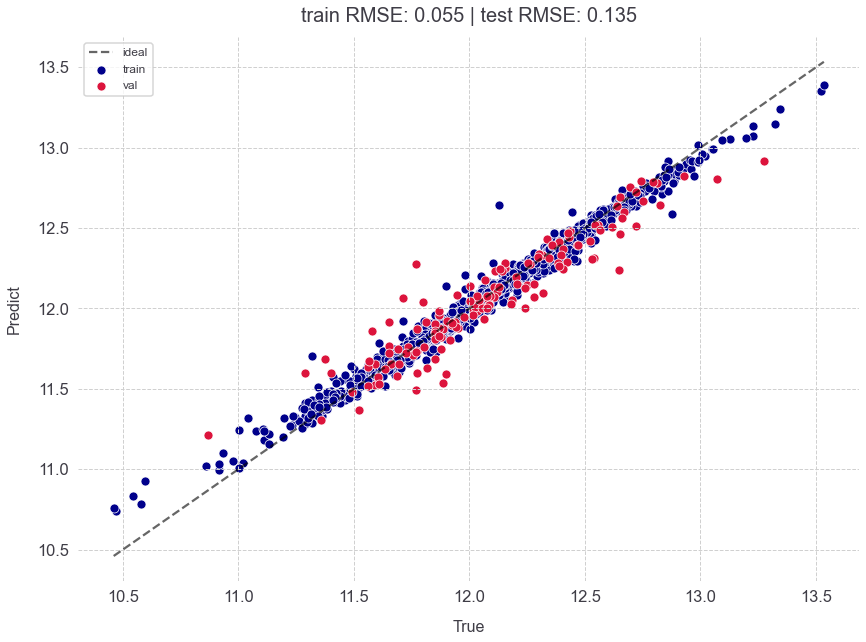

In [17]:
from sklearn.ensemble import RandomForestRegressor

model0 = RandomForestRegressor().fit(X_train, y_train)
true_pred_clouds(model0, X_train, X_test, y_train, y_test)

In [18]:
X_i = keras.layers.Input(shape=(X.shape[1]))
X_d = keras.layers.Dense(120, 'relu')(X_i)
X_d = keras.layers.Dropout(0.5)(X_d)
X_d = keras.layers.Dense(80, 'relu')(X_d)
X_d = keras.layers.Dropout(0.5)(X_d)
X_d = keras.layers.Dense(60, 'relu')(X_d)
X_d = keras.layers.Dense(30, 'relu')(X_d)
X_d = keras.layers.Dense(1, 'linear')(X_d)

model_k = keras.models.Model(inputs=X_i, outputs=X_d)
model_k.compile(optimizer=keras.optimizers.Adam(2e-4), loss='mse', metrics=['mae'])

In [19]:
model_k.fit(X_train, y_train, batch_size=8, epochs=555, validation_data=(X_test, y_test))

Epoch 1/555
165/165 [==============================] - 1s 2ms/step - loss: 72.3075 - mae: 7.5883 - val_loss: 1.9418 - val_mae: 1.1504
Epoch 2/555
165/165 [==============================] - 0s 976us/step - loss: 10.1949 - mae: 2.5709 - val_loss: 4.1199 - val_mae: 1.8932
Epoch 3/555
165/165 [==============================] - 0s 957us/step - loss: 8.7625 - mae: 2.3210 - val_loss: 5.2099 - val_mae: 2.1915
Epoch 4/555
165/165 [==============================] - 0s 951us/step - loss: 7.6875 - mae: 2.2221 - val_loss: 4.5433 - val_mae: 2.0474
Epoch 5/555
165/165 [==============================] - 0s 976us/step - loss: 6.6383 - mae: 2.0526 - val_loss: 6.3087 - val_mae: 2.4405
Epoch 6/555
165/165 [==============================] - 0s 951us/step - loss: 5.6947 - mae: 1.8902 - val_loss: 8.0546 - val_mae: 2.7772
Epoch 7/555
165/165 [==============================] - 0s 957us/step - loss: 5.7085 - mae: 1.8873 - val_loss: 7.7783 - val_mae: 2.7334
Epoch 8/555
165/165 [==============================] - 

165/165 [==============================] - 0s 957us/step - loss: 0.4187 - mae: 0.5199 - val_loss: 7.4457 - val_mae: 2.7078
Epoch 62/555
165/165 [==============================] - 0s 945us/step - loss: 0.3709 - mae: 0.4889 - val_loss: 6.0563 - val_mae: 2.4378
Epoch 63/555
165/165 [==============================] - 0s 1ms/step - loss: 0.3675 - mae: 0.4849 - val_loss: 5.5394 - val_mae: 2.3262
Epoch 64/555
165/165 [==============================] - 0s 1ms/step - loss: 0.3194 - mae: 0.4505 - val_loss: 4.3538 - val_mae: 2.0581
Epoch 65/555
165/165 [==============================] - 0s 969us/step - loss: 0.3061 - mae: 0.4332 - val_loss: 3.7695 - val_mae: 1.9122
Epoch 66/555
165/165 [==============================] - 0s 951us/step - loss: 0.2549 - mae: 0.4006 - val_loss: 3.0650 - val_mae: 1.7207
Epoch 67/555
165/165 [==============================] - 0s 982us/step - loss: 0.2199 - mae: 0.3727 - val_loss: 2.5151 - val_mae: 1.5512
Epoch 68/555
165/165 [==============================] - 0s 951us/

165/165 [==============================] - 0s 1ms/step - loss: 0.0190 - mae: 0.1030 - val_loss: 0.0437 - val_mae: 0.1573
Epoch 182/555
165/165 [==============================] - 0s 957us/step - loss: 0.0190 - mae: 0.1039 - val_loss: 0.0395 - val_mae: 0.1526
Epoch 183/555
165/165 [==============================] - 0s 976us/step - loss: 0.0210 - mae: 0.1057 - val_loss: 0.0297 - val_mae: 0.1294
Epoch 184/555
165/165 [==============================] - 0s 951us/step - loss: 0.0211 - mae: 0.1073 - val_loss: 0.0508 - val_mae: 0.1708
Epoch 185/555
165/165 [==============================] - 0s 944us/step - loss: 0.0191 - mae: 0.1039 - val_loss: 0.0328 - val_mae: 0.1352
Epoch 186/555
165/165 [==============================] - 0s 1ms/step - loss: 0.0194 - mae: 0.1017 - val_loss: 0.0276 - val_mae: 0.1248
Epoch 187/555
165/165 [==============================] - 0s 982us/step - loss: 0.0208 - mae: 0.1044 - val_loss: 0.0269 - val_mae: 0.1225
Epoch 188/555
165/165 [==============================] - 0s

Epoch 241/555
165/165 [==============================] - 0s 945us/step - loss: 0.0140 - mae: 0.0889 - val_loss: 0.0266 - val_mae: 0.1216
Epoch 242/555
165/165 [==============================] - 0s 951us/step - loss: 0.0163 - mae: 0.0948 - val_loss: 0.0322 - val_mae: 0.1354
Epoch 243/555
165/165 [==============================] - 0s 951us/step - loss: 0.0162 - mae: 0.0918 - val_loss: 0.0409 - val_mae: 0.1529
Epoch 244/555
165/165 [==============================] - 0s 951us/step - loss: 0.0140 - mae: 0.0893 - val_loss: 0.0446 - val_mae: 0.1658
Epoch 245/555
165/165 [==============================] - 0s 945us/step - loss: 0.0140 - mae: 0.0890 - val_loss: 0.0527 - val_mae: 0.1821
Epoch 246/555
165/165 [==============================] - 0s 933us/step - loss: 0.0154 - mae: 0.0908 - val_loss: 0.0250 - val_mae: 0.1190
Epoch 247/555
165/165 [==============================] - 0s 935us/step - loss: 0.0166 - mae: 0.0935 - val_loss: 0.0349 - val_mae: 0.1479
Epoch 248/555
165/165 [==================

Epoch 301/555
165/165 [==============================] - 0s 957us/step - loss: 0.0140 - mae: 0.0857 - val_loss: 0.0290 - val_mae: 0.1324
Epoch 302/555
165/165 [==============================] - 0s 957us/step - loss: 0.0130 - mae: 0.0840 - val_loss: 0.0433 - val_mae: 0.1697
Epoch 303/555
165/165 [==============================] - 0s 970us/step - loss: 0.0120 - mae: 0.0796 - val_loss: 0.0305 - val_mae: 0.1359
Epoch 304/555
165/165 [==============================] - 0s 998us/step - loss: 0.0127 - mae: 0.0832 - val_loss: 0.0375 - val_mae: 0.1503
Epoch 305/555
165/165 [==============================] - 0s 1ms/step - loss: 0.0108 - mae: 0.0778 - val_loss: 0.0331 - val_mae: 0.1403
Epoch 306/555
165/165 [==============================] - 0s 1ms/step - loss: 0.0119 - mae: 0.0802 - val_loss: 0.0330 - val_mae: 0.1425
Epoch 307/555
165/165 [==============================] - 0s 982us/step - loss: 0.0128 - mae: 0.0827 - val_loss: 0.0326 - val_mae: 0.1389
Epoch 308/555
165/165 [======================

Epoch 361/555
165/165 [==============================] - 0s 933us/step - loss: 0.0107 - mae: 0.0766 - val_loss: 0.0298 - val_mae: 0.1355
Epoch 362/555
165/165 [==============================] - 0s 933us/step - loss: 0.0107 - mae: 0.0747 - val_loss: 0.0298 - val_mae: 0.1371
Epoch 363/555
165/165 [==============================] - 0s 943us/step - loss: 0.0106 - mae: 0.0766 - val_loss: 0.0275 - val_mae: 0.1319
Epoch 364/555
165/165 [==============================] - 0s 951us/step - loss: 0.0114 - mae: 0.0793 - val_loss: 0.0314 - val_mae: 0.1392
Epoch 365/555
165/165 [==============================] - 0s 945us/step - loss: 0.0106 - mae: 0.0757 - val_loss: 0.0329 - val_mae: 0.1398
Epoch 366/555
165/165 [==============================] - 0s 951us/step - loss: 0.0113 - mae: 0.0791 - val_loss: 0.0346 - val_mae: 0.1449
Epoch 367/555
165/165 [==============================] - 0s 939us/step - loss: 0.0098 - mae: 0.0741 - val_loss: 0.0398 - val_mae: 0.1536
Epoch 368/555
165/165 [==================

165/165 [==============================] - 0s 1ms/step - loss: 0.0098 - mae: 0.0737 - val_loss: 0.0293 - val_mae: 0.1301
Epoch 482/555
165/165 [==============================] - 0s 957us/step - loss: 0.0094 - mae: 0.0728 - val_loss: 0.0249 - val_mae: 0.1207
Epoch 483/555
165/165 [==============================] - 0s 1ms/step - loss: 0.0092 - mae: 0.0696 - val_loss: 0.0318 - val_mae: 0.1393
Epoch 484/555
165/165 [==============================] - 0s 942us/step - loss: 0.0078 - mae: 0.0664 - val_loss: 0.0374 - val_mae: 0.1485
Epoch 485/555
165/165 [==============================] - 0s 945us/step - loss: 0.0074 - mae: 0.0642 - val_loss: 0.0446 - val_mae: 0.1671
Epoch 486/555
165/165 [==============================] - 0s 1ms/step - loss: 0.0088 - mae: 0.0680 - val_loss: 0.0292 - val_mae: 0.1297
Epoch 487/555
165/165 [==============================] - 0s 1ms/step - loss: 0.0104 - mae: 0.0747 - val_loss: 0.0327 - val_mae: 0.1338
Epoch 488/555
165/165 [==============================] - 0s 100

(<Figure size 1008x720 with 1 Axes>,
 <AxesSubplot:title={'center':'train RMSE: 0.118 | test RMSE: 0.181'}, xlabel='True', ylabel='Predict'>)

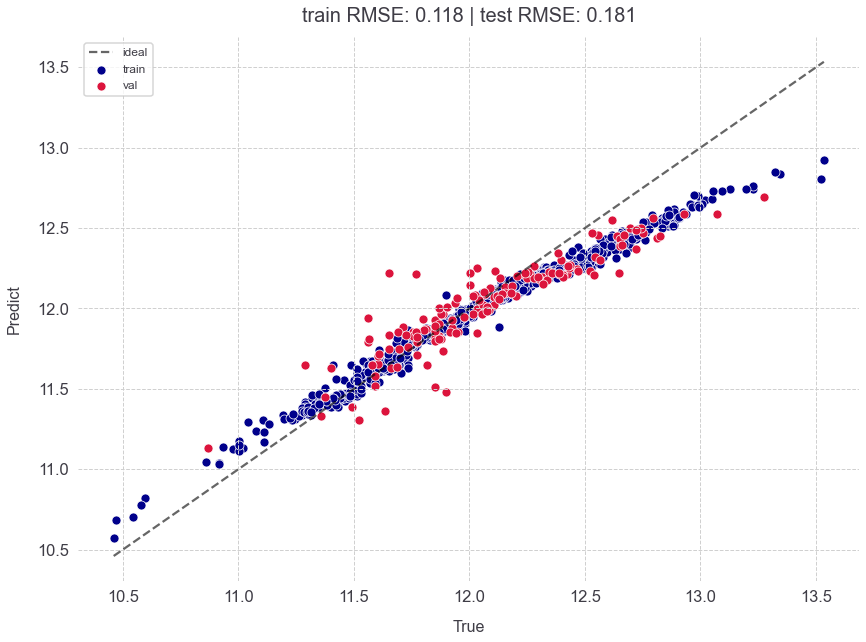

In [21]:
true_pred_clouds(model_k, X_train, X_test, y_train, y_test)

(<Figure size 1008x720 with 1 Axes>,
 <AxesSubplot:title={'center':'train RMSE: 0.078 | test RMSE: 0.122'}, xlabel='True', ylabel='Predict'>)

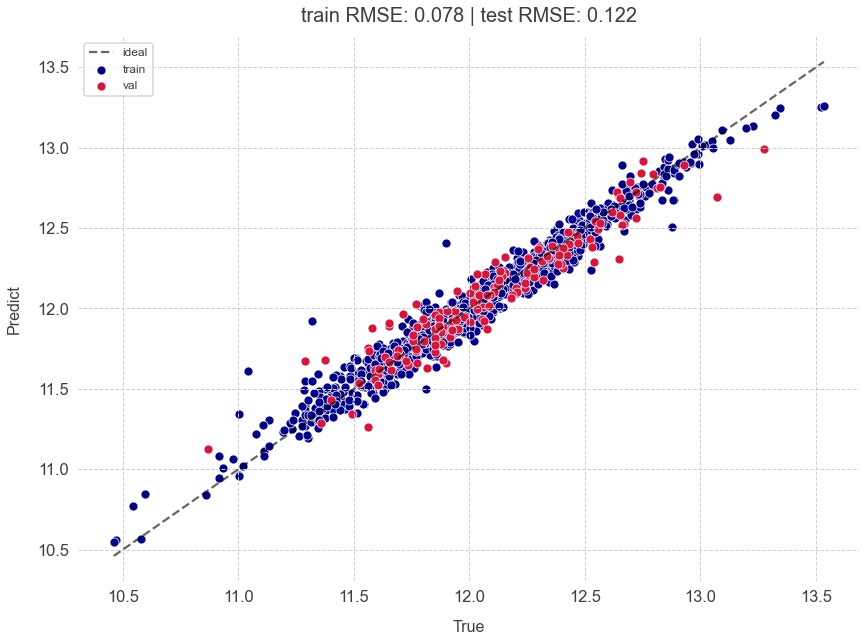

In [22]:
import xgboost

model1 = xgboost.XGBRegressor(n_estimators=60, max_depth=4, reg_alpha=1).fit(X_train, y_train)
true_pred_clouds(model1, X_train, X_test, y_train, y_test)

Let's check the stacked model and its performance

(<Figure size 1008x720 with 1 Axes>,
 <AxesSubplot:title={'center':'train RMSE: 0.066 | test RMSE: 0.129'}, xlabel='True', ylabel='Predict'>)

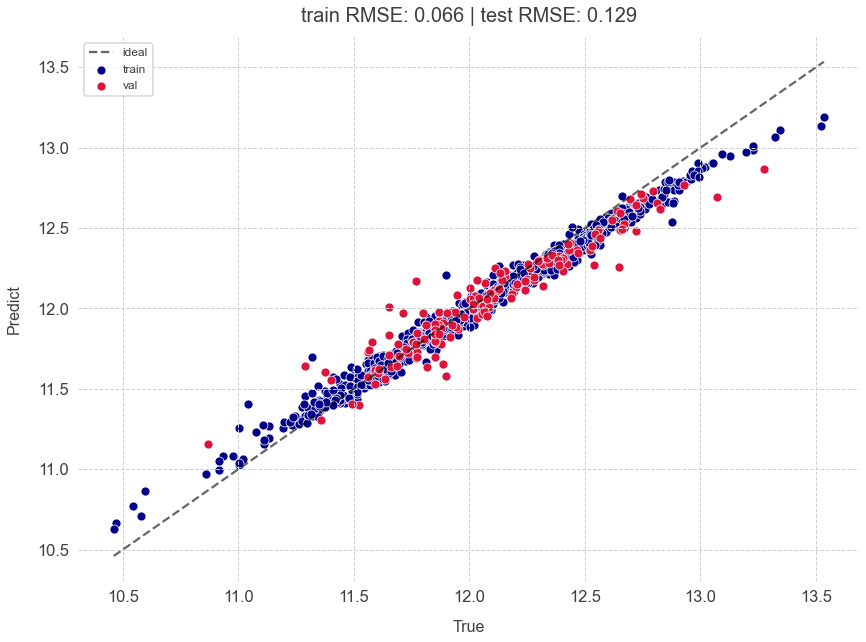

In [23]:
from sklearn.metrics import mean_squared_error as mse

class StackedModel:
    
    def __init__(self, models: list):
        
        self.models = models
    
    def predict(self, data):
        
        preds = []
        
        for model in self.models:
            
            pred = model.predict(data)
            
            if len(pred.shape) < 2:
                pred = np.expand_dims(pred, -1)
            
            preds.append(pred)
        
        return np.mean(np.concatenate(preds, 1), 1)



stacked = StackedModel([model_k, model0, model1])
true_pred_clouds(stacked, X_train, X_test, y_train, y_test)

It's better - let's train for the whole data and apply for testing

In [24]:
rf = RandomForestRegressor().fit(X, y)

kr = keras.models.Model(inputs=X_i, outputs=X_d)
kr.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
kr.fit(X, y, batch_size=16, epochs=555)

xg = xgboost.XGBRegressor(n_estimators=60, max_depth=4, reg_alpha=1).fit(X, y)

stacked_whole = StackedModel([rf, kr, xg])

Epoch 1/555
92/92 [==============================] - 0s 956us/step - loss: 0.0101 - mae: 0.0715
Epoch 2/555
92/92 [==============================] - 0s 912us/step - loss: 0.0082 - mae: 0.0650
Epoch 3/555
92/92 [==============================] - 0s 923us/step - loss: 0.0086 - mae: 0.0648
Epoch 4/555
92/92 [==============================] - 0s 945us/step - loss: 0.0073 - mae: 0.0613
Epoch 5/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0086 - mae: 0.0646
Epoch 6/555
92/92 [==============================] - 0s 999us/step - loss: 0.0086 - mae: 0.0645
Epoch 7/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0082 - mae: 0.0628
Epoch 8/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0072 - mae: 0.0616
Epoch 9/555
92/92 [==============================] - 0s 912us/step - loss: 0.0083 - mae: 0.0645
Epoch 10/555
92/92 [==============================] - 0s 901us/step - loss: 0.0078 - mae: 0.0629
Epoch 11/555
92/92 [=========================

92/92 [==============================] - 0s 989us/step - loss: 0.0058 - mae: 0.0569
Epoch 170/555
92/92 [==============================] - 0s 945us/step - loss: 0.0062 - mae: 0.0565
Epoch 171/555
92/92 [==============================] - 0s 934us/step - loss: 0.0058 - mae: 0.0560
Epoch 172/555
92/92 [==============================] - 0s 913us/step - loss: 0.0054 - mae: 0.0535
Epoch 173/555
92/92 [==============================] - 0s 956us/step - loss: 0.0061 - mae: 0.0562
Epoch 174/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0057 - mae: 0.0549
Epoch 175/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0057 - mae: 0.0546
Epoch 176/555
92/92 [==============================] - 0s 956us/step - loss: 0.0058 - mae: 0.0542
Epoch 177/555
92/92 [==============================] - 0s 989us/step - loss: 0.0058 - mae: 0.0562
Epoch 178/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0061 - mae: 0.0574
Epoch 179/555
92/92 [===================

Epoch 253/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0054 - mae: 0.0541
Epoch 254/555
92/92 [==============================] - 0s 945us/step - loss: 0.0061 - mae: 0.0561
Epoch 255/555
92/92 [==============================] - 0s 978us/step - loss: 0.0057 - mae: 0.0547
Epoch 256/555
92/92 [==============================] - 0s 923us/step - loss: 0.0062 - mae: 0.0552
Epoch 257/555
92/92 [==============================] - 0s 901us/step - loss: 0.0057 - mae: 0.0549
Epoch 258/555
92/92 [==============================] - 0s 934us/step - loss: 0.0061 - mae: 0.0562
Epoch 259/555
92/92 [==============================] - 0s 945us/step - loss: 0.0059 - mae: 0.0549
Epoch 260/555
92/92 [==============================] - 0s 945us/step - loss: 0.0057 - mae: 0.0527
Epoch 261/555
92/92 [==============================] - 0s 912us/step - loss: 0.0052 - mae: 0.0533
Epoch 262/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0055 - mae: 0.0538
Epoch 263/555
92/92 [===

92/92 [==============================] - 0s 890us/step - loss: 0.0054 - mae: 0.0520
Epoch 420/555
92/92 [==============================] - 0s 913us/step - loss: 0.0055 - mae: 0.0511
Epoch 421/555
92/92 [==============================] - 0s 923us/step - loss: 0.0055 - mae: 0.0540
Epoch 422/555
92/92 [==============================] - 0s 956us/step - loss: 0.0044 - mae: 0.0489
Epoch 423/555
92/92 [==============================] - 0s 923us/step - loss: 0.0052 - mae: 0.0515
Epoch 424/555
92/92 [==============================] - 0s 901us/step - loss: 0.0058 - mae: 0.0538
Epoch 425/555
92/92 [==============================] - 0s 923us/step - loss: 0.0059 - mae: 0.0526
Epoch 426/555
92/92 [==============================] - 0s 901us/step - loss: 0.0052 - mae: 0.0519
Epoch 427/555
92/92 [==============================] - 0s 912us/step - loss: 0.0053 - mae: 0.0526
Epoch 428/555
92/92 [==============================] - 0s 890us/step - loss: 0.0056 - mae: 0.0536
Epoch 429/555
92/92 [=============

92/92 [==============================] - 0s 935us/step - loss: 0.0046 - mae: 0.0494
Epoch 504/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0046 - mae: 0.0488
Epoch 505/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0052 - mae: 0.0512
Epoch 506/555
92/92 [==============================] - 0s 1000us/step - loss: 0.0048 - mae: 0.0504
Epoch 507/555
92/92 [==============================] - 0s 967us/step - loss: 0.0051 - mae: 0.0521
Epoch 508/555
92/92 [==============================] - 0s 945us/step - loss: 0.0045 - mae: 0.0485
Epoch 509/555
92/92 [==============================] - 0s 923us/step - loss: 0.0046 - mae: 0.0503
Epoch 510/555
92/92 [==============================] - 0s 982us/step - loss: 0.0047 - mae: 0.0501
Epoch 511/555
92/92 [==============================] - 0s 1ms/step - loss: 0.0051 - mae: 0.0515
Epoch 512/555
92/92 [==============================] - 0s 912us/step - loss: 0.0047 - mae: 0.0496
Epoch 513/555
92/92 [==================

Test data processing

In [29]:
test = pd.read_csv('test.csv')

# rank features
test = convert_to_ranked(test)

# ohe-hot encoded features
ohe_df_test = pd.DataFrame(data=ohe.transform(test[_ONEHOT]), columns=ohe.get_feature_names(_ONEHOT))
test[ohe_important] = ohe_df_test[ohe_important].copy()
test.drop(_ONEHOT, inplace=True, axis=1)

# artificial features
test['GarageYrBlt'].fillna(0, inplace=True)

test['Age'] = test['YrSold'] - test['YearBuilt']
test['AgeRemod'] = test['YrSold'] - test['YearRemodAdd']
test['GarageAge'] = (test['YrSold'] - test['GarageYrBlt']) * (test['GarageYrBlt'] > 0).astype(int)

test.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

# poor corrs
test.drop(temp_poor, axis=1, inplace=True)

# filling nans
test.fillna(0, inplace=True)

# scaling
test = scaler.transform(test)

In [30]:
# generate predict
predict = stacked_whole.predict(test)

# don't forget to apply exp (earlier log was applied)
predict = np.exp(predict)

test_output = pd.DataFrame(data={'idx' : test.index, target : predict})

In [31]:
test_output.SalePrice.describe()

count      1459.000000
mean     172813.224027
std       65961.531978
min       52190.810127
25%      129433.952816
50%      156427.933621
75%      202745.429350
max      442670.187142
Name: SalePrice, dtype: float64

In [32]:
# save to csv
test_output.to_csv('test_predict.csv', index=False)